In [157]:
import os
import rootpath
import sys
sys.path.append(rootpath.detect())

import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

In [811]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
if not os.path.isdir('./figures'):
    os.makedirs("./figures")

In [158]:
from scipy.stats import wilcoxon

In [808]:
import matplotlib
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator


matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [794]:
def save_fig(fig, name=None):
    figname_stub = script_dir.split('/')[-1]
    if name is None:
        filename = figname_stub+"_"+fig.get_title()
    else:
        filename = figname_stub+"_"+name
    
    savedirs = [os.path.join(script_dir, "figures/"),
                "/home/finley/phd/papers/SAF-driven-EMO/figures/"]
    for d in savedirs:
        fig.savefig(os.path.join(d, filename+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, filename+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')
    

In [159]:
REPORT_TABLE_DIR= '/home/finley/phd/papers/SAF-driven-EMO/tables/'
X_LIMIT = 150

In [160]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [161]:
def add_com(df, mask, com):
    best_inds =  [*zip(*np.where(mask == 1))] 
    for i, j in best_inds:
        df.iloc[i, j] = com + df.iloc[i, j]
    return df

In [162]:
def IQR(dist, axis):
    return np.percentile(dist, 75, axis=axis) - np.percentile(dist, 25, axis=axis)

In [163]:
def gen_table(d, result_min=0, result_max=6):
    h, w = d.shape
    headers = pd.MultiIndex.from_product([[c.replace('_', ' ').replace('wfg', 'WFG') for c in chosen_results[result_min:result_max]], ['Median', 'IQR']])
    df = pd.DataFrame(data=d.round(3).astype(str), index=true_names, columns=headers)
    return df, d

In [164]:
def gen_table_matrix(measure, result_min=0, result_max=6):
    if measure == 'igd+':
        invert=True
    else:
        invert=False
    # data matrix
    D = np.zeros((len(optimisers), len(chosen_results[result_min:result_max])*2))
    # mask of best values
    best_mask = np.zeros_like(D)
    # mask of equivalent values
    best_opts = []
    
    for i, prob in enumerate(chosen_results[result_min:result_max]):
        if invert:
            best_value = np.inf
        else:
            best_value = 0 
        best_index = 0
        for j, opt in enumerate(optimisers):
            med = np.median(results[prob]['data'][opt][measure], axis=0)[X_LIMIT]
            D[j, i*2] = med 
            D[j, i*2+1] = IQR(results[prob]['data'][opt][measure], axis=0)[X_LIMIT]
            if (med>best_value and invert == False) or (med<best_value and invert == True):
                best_value=med
                best_index = j
        best_mask[best_index, i*2] = True
        best_mask[best_index, i*2+1] = True
        best_opts.append(optimisers[best_index])
    
    eqv_mask = np.zeros_like(D)
    for i, prob in enumerate(chosen_results[result_min:result_max]):
        P = []
        for j, opt in enumerate(optimisers):
            if opt != best_opts[i]:
                hv = results[prob]['data'][opt][measure]
                bv = results[prob]['data'][best_opts[i]][measure]
                w, p = wilcoxon(bv[:, -1], hv[:, -1])
#                 print(p)
#                 print(bv[:, -1], "\n", hv[:, -1])
#                 print()
                P.append(p)
        p_inds = np.argsort(P)
        for ind, m in zip(p_inds, [r for r in range(len(P), 0, -1)]):
            if P[ind]>=(0.05/m):
                if optimisers[ind] == best_opts[i]:
                    pass
                else:
                    eqv_mask[ind, i*2] = True
                    eqv_mask[ind, i*2+1] = True
    return D, best_mask, eqv_mask

In [165]:
sw = ((31*(31+1)*(2*31+1))/6)**0.5 
sw

102.05880657738459

In [166]:
parent_dir = os.path.join(rootpath.detect(), 'experiments/data')

In [167]:
results = {o:{'path':os.path.join(parent_dir, o, 'pkl_data/results_new.pkl')} for o in os.listdir(parent_dir) if o[:3] == 'wfg'}

In [168]:
for key, result in results.items():
    with open(result['path'], 'rb') as infile:
        results[key]['data'] = pkl.load(infile) 

In [169]:
chosen_results = [
    'wfg1_2obj_3dim', 
    'wfg1_3obj_4dim', 
    'wfg1_4obj_5dim', 
    'wfg2_2obj_6dim', 
    'wfg2_3obj_6dim', 
    'wfg2_4obj_10dim', 
    'wfg3_2obj_6dim', 
    'wfg3_3obj_10dim', 
    'wfg3_4obj_10dim_2', 
    'wfg4_2obj_6dim', 
    'wfg4_3obj_8dim', 
    'wfg4_4obj_8dim', 
    'wfg5_2obj_6dim', 
    'wfg5_3obj_8dim', 
    'wfg5_4obj_10dim', 
    'wfg6_2obj_10dim', 
    'wfg6_3obj_6dim', 
    'wfg6_4obj_12dim']

In [170]:
optimisers = list(results[chosen_results[0]]['data'].keys())
optimisers

['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']

In [171]:
d, bm, em = gen_table_matrix('hypervolume', result_min=0, result_max=6)
T_hv_1= gen_table(d, result_min=0, result_max=6)[0]
T_hv_1 = add_com(T_hv_1, bm, r'\best ')
T_hv_1 = add_com(T_hv_1, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_1.tex'), "w") as outfile:
    print(T_hv_1.to_latex(index=True, escape=False), file=outfile)
T_hv_1

WFG1 2obj 3dim                    WFG1 3obj 4dim  \
                            Median                IQR         Median   
MPoI                         8.014              2.178         66.911   
ParEGO                  \best 9.08        \best 0.315         82.528   
SAF: ei                        6.0              0.442         54.753   
SAF: $\mu$                   8.565              0.355         77.134   
SMS-EGO: ei     \statsimilar 8.703  \statsimilar 0.39         77.227   
SMS-EGO: $\mu$               8.862              0.499   \best 86.482   
LHS                          4.368              0.375         32.846   

                                  WFG1 4obj 5dim                      \
                        IQR               Median                 IQR   
MPoI                  10.74                19.12               4.523   
ParEGO               13.576               23.997               3.208   
SAF: ei               8.513                20.91               1.743   
SAF: $\mu$           13.502   \statsimilar 24.96  \statsimilar 4.834   
SMS-EGO: ei          10.582  \statsimilar 24.906  \statsimilar 3.133   
SMS-EGO: $\mu$  \best 4.955         \best 25.491         \best 1.395   
LHS                   3.288               12.654               1.085   

               WFG2 2obj 6dim                   WFG2 3obj 6dim  \
                       Median         IQR               Median   
MPoI                    3.489       0.952    \statsimilar 39.7   
ParEGO            \best 4.117  \best 0.46         \best 40.951   
SAF: ei                 3.696       0.414   \statsimilar 38.84   
SAF: $\mu$              3.972        0.35  \statsimilar 39.833   
SMS-EGO: ei             3.396       0.765  \statsimilar 40.712   
SMS-EGO: $\mu$          3.828       0.674               39.402   
LHS                     3.933       0.286               36.959   

                                   WFG2 4obj 10dim               
                               IQR          Median          IQR  
MPoI            \statsimilar 4.519          43.814        7.965  
ParEGO                  \best 3.43    \best 56.359  \best 6.711  
SAF: ei         \statsimilar 2.158          52.663        9.741  
SAF: $\mu$      \statsimilar 4.261          53.373        7.101  
SMS-EGO: ei     \statsimilar 2.973          48.798        7.954  
SMS-EGO: $\mu$               3.439          49.738        8.956  
LHS                           2.61          45.824        6.523

In [751]:
d, bm, em = gen_table_matrix('hypervolume', result_min=6, result_max=12)
T_hv_2= gen_table(d, result_min=6, result_max=12)[0]
T_hv_2 = add_com(T_hv_2, bm, r'\best ')
T_hv_2 = add_com(T_hv_2, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_2.tex'), "w") as outfile:
    print(T_hv_2.to_latex(index=True, escape=False), file=outfile)
T_hv_2

WFG3 2obj 6dim              WFG3 3obj 10dim               \
                       Median          IQR          Median          IQR   
MPoI                    4.161        0.583            2.95          1.6   
ParEGO                  4.271        0.281           4.182        1.324   
SAF: ei                 5.022        0.151           4.828        0.426   
SAF: $\mu$              5.397        0.056           5.177         0.38   
SMS-EGO: ei             5.382        0.129           5.273        0.599   
SMS-EGO: $\mu$     \best 5.44  \best 0.058     \best 5.564  \best 0.419   
LHS                     3.522        0.173            2.36        0.231   

                 WFG3 4obj 10dim 2                          WFG4 2obj 6dim  \
                            Median                 IQR              Median   
MPoI                        17.382                6.09               1.831   
ParEGO                      25.577               2.815               2.246   
SAF: ei                      24.88               3.317  \statsimilar 2.365   
SAF: $\mu$                  21.648               4.477  \statsimilar 2.411   
SMS-EGO: ei     \statsimilar 26.37  \statsimilar 3.752               2.163   
SMS-EGO: $\mu$        \best 27.664         \best 3.571          \best 2.46   
LHS                         11.298               2.626               2.011   

                                         WFG4 3obj 8dim                      \
                               IQR               Median                 IQR   
MPoI                         0.384               18.868               2.253   
ParEGO                       0.267               19.262               2.785   
SAF: ei         \statsimilar 0.171  \statsimilar 22.979  \statsimilar 1.422   
SAF: $\mu$      \statsimilar 0.252  \statsimilar 22.988  \statsimilar 0.956   
SMS-EGO: ei                  0.269               21.902               2.882   
SMS-EGO: $\mu$         \best 0.229         \best 23.559         \best 2.255   
LHS                           0.12               16.773               0.474   

                      WFG4 4obj 8dim                       
                              Median                  IQR  
MPoI                          181.44               48.613  
ParEGO                       219.596                43.53  
SAF: ei                      252.931               30.746  
SAF: $\mu$                   266.742               19.645  
SMS-EGO: ei     \statsimilar 265.644  \statsimilar 39.496  
SMS-EGO: $\mu$         \best 276.929         \best 22.789  
LHS                          162.876                  7.9

In [784]:
d, bm, em = gen_table_matrix('hypervolume', result_min=12, result_max=18)
T_hv_3= gen_table(d, result_min=12, result_max=18)[0]
T_hv_3 = add_com(T_hv_3, bm, r'\best ')
T_hv_3 = add_com(T_hv_3, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_3.tex'), "w") as outfile:
    print(T_hv_3.to_latex(index=True, escape=False), file=outfile)
T_hv_3

WFG5 2obj 6dim              WFG5 3obj 8dim               \
                       Median          IQR         Median          IQR   
MPoI                    2.336        0.294         21.544        3.489   
ParEGO                  2.542        0.228         20.202        3.118   
SAF: ei                 1.999        0.227         19.362        3.069   
SAF: $\mu$              2.523        0.172   \best 24.009  \best 2.271   
SMS-EGO: ei       \best 2.678  \best 0.242         22.558        2.832   
SMS-EGO: $\mu$          2.499        0.314          22.09         3.43   
LHS                     1.464        0.138         14.149        0.767   

               WFG5 4obj 10dim               WFG6 2obj 10dim               \
                        Median           IQR          Median          IQR   
MPoI                   184.144        45.456           1.547        0.437   
ParEGO                 192.749         28.43           1.964        0.396   
SAF: ei                185.143        28.515           2.247        0.255   
SAF: $\mu$       \best 232.378  \best 21.164     \best 2.685  \best 0.295   
SMS-EGO: ei            196.129        31.265           2.231         0.69   
SMS-EGO: $\mu$         197.441        26.436           2.065        0.482   
LHS                    139.934         7.754           0.982        0.137   

               WFG6 3obj 6dim                    WFG6 4obj 12dim  \
                       Median          IQR                Median   
MPoI                   24.546        4.222               156.159   
ParEGO                 17.465        2.807               158.553   
SAF: ei                26.229        3.077               162.452   
SAF: $\mu$             30.679        1.578               188.764   
SMS-EGO: ei      \best 31.568  \best 1.482  \statsimilar 222.013   
SMS-EGO: $\mu$         30.786        1.975         \best 228.714   
LHS                     14.47        1.314               122.898   

                                     
                                IQR  
MPoI                         34.453  
ParEGO                       26.332  
SAF: ei                      20.349  
SAF: $\mu$                   18.704  
SMS-EGO: ei     \statsimilar 21.301  
SMS-EGO: $\mu$         \best 13.249  
LHS                           3.605

In [174]:
d, bm, em = gen_table_matrix('igd+', result_min=0, result_max=6)
T_igd_1= gen_table(d, result_min=0, result_max=6)[0]
T_igd_1 = add_com(T_igd_1, bm, r'\best ')
T_igd_1 = add_com(T_igd_1, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_1.tex'), "w") as outfile:
    print(T_igd_1.to_latex(index=True, escape=False), file=outfile)
T_igd_1

WFG1 2obj 3dim                          WFG1 3obj 4dim  \
                            Median                 IQR              Median   
MPoI                         1.063               0.269               1.483   
ParEGO                 \best 0.969         \best 0.036  \statsimilar 1.318   
SAF: ei                      1.324               0.067               1.636   
SAF: $\mu$                   1.014               0.035               1.343   
SMS-EGO: ei     \statsimilar 1.005  \statsimilar 0.043               1.388   
SMS-EGO: $\mu$               0.988               0.051         \best 1.288   
LHS                          1.565               0.055               2.001   

                                        WFG1 4obj 5dim                      \
                               IQR              Median                 IQR   
MPoI                         0.231               1.883               0.187   
ParEGO          \statsimilar 0.113               1.655               0.149   
SAF: ei                        0.1               1.814               0.128   
SAF: $\mu$                   0.184  \statsimilar 1.621  \statsimilar 0.187   
SMS-EGO: ei                  0.144  \statsimilar 1.598  \statsimilar 0.136   
SMS-EGO: $\mu$         \best 0.046         \best 1.564         \best 0.066   
LHS                          0.048               2.289               0.066   

               WFG2 2obj 6dim                   WFG2 3obj 6dim  \
                       Median          IQR              Median   
MPoI                    0.561         0.22         \best 0.653   
ParEGO            \best 0.433  \best 0.083               0.746   
SAF: ei                 0.553        0.094               0.891   
SAF: $\mu$               0.53        0.101  \statsimilar 0.818   
SMS-EGO: ei             0.592        0.172  \statsimilar 0.756   
SMS-EGO: $\mu$          0.521        0.144               0.787   
LHS                     0.493        0.076               0.838   

                                   WFG2 4obj 10dim               
                               IQR          Median          IQR  
MPoI                   \best 0.161           0.652        0.178  
ParEGO                       0.201      \best 0.55  \best 0.159  
SAF: ei                      0.212           0.646        0.208  
SAF: $\mu$      \statsimilar 0.258           0.639        0.224  
SMS-EGO: ei     \statsimilar 0.252           0.718        0.177  
SMS-EGO: $\mu$               0.141           0.703        0.281  
LHS                          0.186           0.633        0.075

In [175]:
d, bm, em = gen_table_matrix('igd+', result_min=6, result_max=12)
T_igd_2= gen_table(d, result_min=6, result_max=12)[0]
T_igd_2 = add_com(T_igd_2, bm, r'\best ')
T_igd_2 = add_com(T_igd_2, em, r'\statsimilar ')

with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_2.tex'), "w") as outfile:
    print(T_igd_2.to_latex(index=True, escape=False), file=outfile)
T_igd_2

WFG3 2obj 6dim                        WFG3 3obj 10dim  \
                            Median                IQR              Median   
MPoI                          0.28              0.129               0.402   
ParEGO                       0.242              0.052               0.336   
SAF: ei                      0.112              0.031               0.222   
SAF: $\mu$      \statsimilar 0.046  \statsimilar 0.01               0.162   
SMS-EGO: ei                   0.05              0.021  \statsimilar 0.151   
SMS-EGO: $\mu$         \best 0.041         \best 0.01          \best 0.13   
LHS                          0.418              0.047               0.613   

                                   WFG3 4obj 10dim 2               \
                               IQR            Median          IQR   
MPoI                         0.222             0.329        0.189   
ParEGO                       0.211             0.379        0.103   
SAF: ei                      0.068              0.25        0.063   
SAF: $\mu$                   0.042             0.247        0.052   
SMS-EGO: ei     \statsimilar 0.062             0.181        0.059   
SMS-EGO: $\mu$         \best 0.046        \best 0.18  \best 0.056   
LHS                          0.056              0.66        0.071   

                    WFG4 2obj 6dim                          WFG4 3obj 8dim  \
                            Median                 IQR              Median   
MPoI                         0.296               0.076               0.554   
ParEGO                        0.19               0.047               0.545   
SAF: ei          \statsimilar 0.17  \statsimilar 0.032  \statsimilar 0.403   
SAF: $\mu$      \statsimilar 0.166  \statsimilar 0.054  \statsimilar 0.411   
SMS-EGO: ei                  0.213               0.095               0.461   
SMS-EGO: $\mu$         \best 0.161         \best 0.042           \best 0.4   
LHS                          0.316               0.063                0.88   

                                        WFG4 4obj 8dim                      
                               IQR              Median                 IQR  
MPoI                         0.085               0.889               0.591  
ParEGO                       0.166               0.863               0.394  
SAF: ei         \statsimilar 0.042               0.656               0.135  
SAF: $\mu$      \statsimilar 0.054               0.622               0.096  
SMS-EGO: ei                  0.121  \statsimilar 0.583  \statsimilar 0.225  
SMS-EGO: $\mu$         \best 0.077         \best 0.526         \best 0.131  
LHS                          0.112               1.709               0.262

In [176]:
d, bm, em = gen_table_matrix('igd+', result_min=12, result_max=18)
T_igd_3= gen_table(d, result_min=12, result_max=18)[0]
T_igd_3 = add_com(T_igd_3, bm, r'\best ')
T_igd_3 = add_com(T_igd_3, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_3.tex'), "w") as outfile:
    print(T_igd_3.to_latex(index=True, escape=False), file=outfile)
T_igd_3

WFG5 2obj 6dim                          WFG5 3obj 8dim  \
                            Median                 IQR              Median   
MPoI                         0.229               0.099  \statsimilar 0.583   
ParEGO          \statsimilar 0.141  \statsimilar 0.044  \statsimilar 0.539   
SAF: ei                      0.325               0.069               0.675   
SAF: $\mu$                   0.178               0.064         \best 0.458   
SMS-EGO: ei            \best 0.121         \best 0.084               0.582   
SMS-EGO: $\mu$               0.186               0.098               0.553   
LHS                          0.422               0.046               0.778   

                                   WFG5 4obj 10dim               \
                               IQR          Median          IQR   
MPoI            \statsimilar 0.203           1.182         0.37   
ParEGO          \statsimilar 0.126            1.09        0.289   
SAF: ei                      0.234           1.251        0.341   
SAF: $\mu$             \best 0.121     \best 0.872  \best 0.188   
SMS-EGO: ei                  0.213           1.258        0.357   
SMS-EGO: $\mu$               0.281           1.372        0.543   
LHS                          0.073           1.254        0.092   

               WFG6 2obj 10dim                   WFG6 3obj 6dim  \
                        Median          IQR              Median   
MPoI                     0.365        0.094               0.354   
ParEGO                   0.252        0.072               0.556   
SAF: ei                  0.201        0.064               0.319   
SAF: $\mu$         \best 0.123  \best 0.062  \statsimilar 0.203   
SMS-EGO: ei              0.234        0.147         \best 0.188   
SMS-EGO: $\mu$            0.27        0.136               0.218   
LHS                      0.636        0.049               0.691   

                                       WFG6 4obj 12dim                      
                               IQR              Median                 IQR  
MPoI                         0.122               0.893               0.206  
ParEGO                       0.078               1.034               0.209  
SAF: ei                      0.094               0.929               0.063  
SAF: $\mu$      \statsimilar 0.043               0.809               0.088  
SMS-EGO: ei             \best 0.04  \statsimilar 0.696  \statsimilar 0.072  
SMS-EGO: $\mu$               0.049         \best 0.675         \best 0.044  
LHS                          0.063               1.341               0.103

\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{2}{l}{WFG5 2obj 6dim} & \multicolumn{2}{l}{WFG5 3obj 8dim} & \multicolumn{2}{l}{WFG5 4obj 10dim} & \multicolumn{2}{l}{WFG6 2obj 10dim} & \multicolumn{2}{l}{WFG6 3obj 6dim} & \multicolumn{2}{l}{WFG6 4obj 12dim} \\
{} &              Median &                 IQR &              Median &                 IQR &          Median &          IQR &          Median &          IQR &              Median &                 IQR &              Median &                 IQR \\
\midrule
MPoI           &               0.229 &               0.099 &  \statsimilar 0.583 &  \statsimilar 0.203 &           1.182 &         0.37 &           0.365 &        0.094 &               0.354 &               0.122 &               0.893 &               0.206 \\
ParEGO         &  \statsimilar 0.141 &  \statsimilar 0.044 &  \statsimilar 0.539 &  \statsimilar 0.126 &            1.09 &        0.289 &           0.252 &        0.072 &               0.556 &               0.078 &               1.034 &               0.209 \\
SAF: ei        &               0.325 &               0.069 &               0.675 &               0.234 &           1.251 &        0.341 &           0.201 &        0.064 &               0.319 &               0.094 &               0.929 &               0.063 \\
SAF: $\mu$     &               0.178 &               0.064 &         \best 0.458 &         \best 0.121 &     \best 0.872 &  \best 0.188 &     \best 0.123 &  \best 0.062 &  \statsimilar 0.203 &  \statsimilar 0.043 &               0.809 &               0.088 \\
SMS-EGO: ei    &         \best 0.121 &         \best 0.084 &               0.582 &               0.213 &           1.258 &        0.357 &           0.234 &        0.147 &         \best 0.188 &          \best 0.04 &  \statsimilar 0.696 &  \statsimilar 0.072 \\
SMS-EGO: $\mu$ &               0.186 &               0.098 &               0.553 &               0.281 &           1.372 &        0.543 &            0.27 &        0.136 &               0.218 &               0.049 &         \best 0.675 &         \best 0.044 \\
LHS            &               0.422 &               0.046 &               0.778 &               0.073 &           1.254 &        0.092 &           0.636 &        0.049 &               0.691 &               0.063 &               1.341 &               0.103 \\
\bottomrule
\end{tabular}

In [667]:
for c in chosen_results:
    print(c)

wfg1_2obj_3dim
wfg1_3obj_4dim
wfg1_4obj_5dim
wfg2_2obj_6dim
wfg2_3obj_6dim
wfg2_4obj_10dim
wfg3_2obj_6dim
wfg3_3obj_10dim
wfg3_4obj_10dim_2
wfg4_2obj_6dim
wfg4_3obj_8dim
wfg4_4obj_8dim
wfg5_2obj_6dim
wfg5_3obj_8dim
wfg5_4obj_10dim
wfg6_2obj_10dim
wfg6_3obj_6dim
wfg6_4obj_12dim


In [400]:
for r in results['wfg1_2obj_3dim']['data'].keys():
    print(r)

Mpoi
ParEgo
Saf_ei
Saf_$\mu$
SmsEgo_ei
SmsEgo_$\mu$
lhs


- for each problem
    - extract hypervolume data - (7, 31, 250)
    - find medians
    - rank -  (7, 250)
    - find best - (250,)
    - find p values
    - divy rankings
    - sum rans
- do for all opts
- sum

In [711]:
def extract_metric(results, F_name, metric):
    """
    gets a numpy array of data according to the passed metric
    
    :params:
    result dict: dictionary of resukts
    F_name str: test_function name
    metric str: metric to be extracted, either 'hypervolume' or 'igd+'
    
    :returns:
    np.ndarray (n_optimisers, n_repeats, 250) hypervolume data
    """
    # get function specific data 
    F_data = results[F_name]['data']
    
    # extract metric data for all optimisers, clipping lhs to size
    hv_data = np.array([d[metric] if k !="lhs" else d['hypervolume'][:,1:] for k, d in F_data.items() ])
    return hv_data

def rank_metrics(metric, minimise=False):
    meds = np.median(metric, axis=1)
    if minimise:
        best_inds = np.argmin(meds, axis=0)
    else:
        best_inds = np.argmax(meds, axis=0)
    
    if minimise:
        return np.argsort(meds, axis=0).argsort(axis=0), best_inds
    else: 
        return np.argsort(meds, axis=0)[::-1].argsort(axis=0), best_inds

def get_equivalence_single(data, minimise=False):
    assert data.shape == (7, 31)
    ranks, best = rank_metrics(data, minimise=minimise)
    
    for pairing in range(1, ranks.max()):
        w, p = wilcoxon(data[pairing-1], data[pairing])
        if p>0.05:
            ranks[ranks<pairing] = ranks[ranks<pairing]+1
    return ranks-ranks.min()+1


def get_equivalence(data, minimise=False):
    assert data.ndim == 3
    
    ranks = np.zeros((data.shape[0], data.shape[-1]))
    for i in range(data.shape[-1]):
        mod_rank =  get_equivalence_single(data[:,:,i], minimise=minimise)
        ranks[:,i] = mod_rank
    return ranks

In [737]:
HVS = np.zeros((18, 7, 140))
for i, prob in enumerate(chosen_results):
    hvs = extract_metric(results, prob, 'hypervolume')[:, :,10:150]
    rs = get_equivalence(hvs)
    HVS[i] = rs 
HVS.shape

(18, 7, 140)

In [802]:
IGDS = np.zeros((18, 7, 150))
for i, opt in enumerate(chosen_results):
    igds = extract_metric(results, opt, 'igd+')[:, :,0:150]
    rs = get_equivalence(igds, minimise=True)
    IGDS[i] = rs 
IGDS.shape

(18, 7, 150)

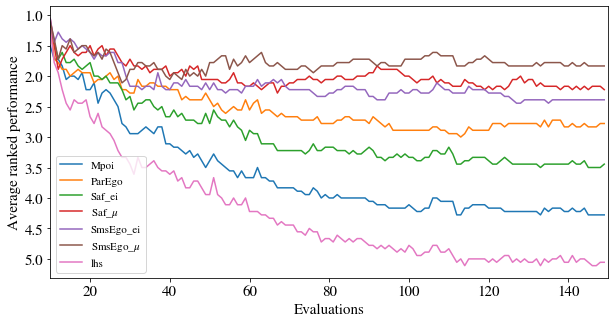

In [824]:
ans = HVS.sum(axis=0)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for a , name in zip(ans, results['wfg5_4obj_10dim']['data'].keys()):
    ax.plot(range(10, len(a)+10), a/18, label=name)
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend()

In [825]:
save_fig(fig, name="ranked_performance_plot_hv")

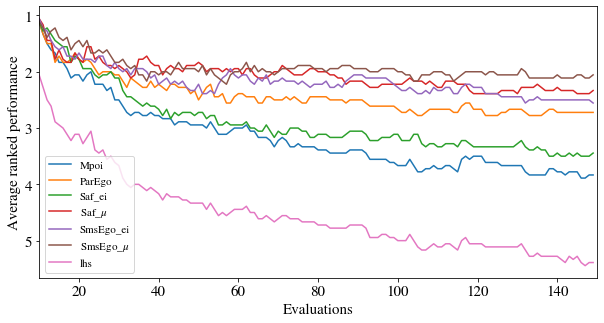

In [822]:
ans = IGDS.sum(axis=0)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for a , name in zip(ans, results['wfg5_4obj_10dim']['data'].keys()):
    ax.plot(range(10, len(a)), a[10:]/18, label=name)
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend()

In [823]:
save_fig(fig, name="ranked_performance_plot_igd")

In [741]:
for r in results['wfg1_2obj_3dim']['data'].keys():
    print(r)

Mpoi
ParEgo
Saf_ei
Saf_$\mu$
SmsEgo_ei
SmsEgo_$\mu$
lhs


In [782]:
# greedy vs ei winners SAF HV
hvs = np.array([extract_metric(results, f, 'hypervolume')[:, :,10:151] for f in chosen_results])
hvs_saf_vs = hvs[:, [2, 3], :, -1]
np.array(chosen_results)[np.invert(np.median(hvs_saf_vs, axis=-1).argmax(axis=0).astype(bool))]

array(['wfg3_4obj_10dim_2'], dtype='<U17')

In [788]:
# greedy vs ei winners SMS HV
hvs = np.array([extract_metric(results, f, 'hypervolume')[:, :,10:151] for f in chosen_results])
hvs_saf_vs = hvs[:, [4, 5], :, -1]
np.array(chosen_results)[np.invert(np.median(hvs_saf_vs, axis=-1).argmax(axis=0).astype(bool))]

array(['wfg2_3obj_6dim', 'wfg5_2obj_6dim', 'wfg5_3obj_8dim',
       'wfg6_2obj_10dim', 'wfg6_3obj_6dim'], dtype='<U17')

In [789]:
# greedy vs ei winners SAF HV
igd = np.array([extract_metric(results, f, 'igd+')[:, :,10:151] for f in chosen_results])
igd_saf_vs = igd[:, [2, 3], :, -1]
np.array(chosen_results)[np.invert(np.median(igd_saf_vs, axis=-1).argmin(axis=0).astype(bool))]

array(['wfg4_3obj_8dim'], dtype='<U17')

In [790]:
# greedy vs ei winners SAF HV
igd = np.array([extract_metric(results, f, 'igd+')[:, :,10:151] for f in chosen_results])
igd_saf_vs = igd[:, [4, 5], :, -1]
np.array(chosen_results)[np.invert(np.median(igd_saf_vs, axis=-1).argmin(axis=0).astype(bool))]

array(['wfg2_3obj_6dim', 'wfg5_2obj_6dim', 'wfg5_4obj_10dim',
       'wfg6_2obj_10dim', 'wfg6_3obj_6dim'], dtype='<U17')